<a href="https://colab.research.google.com/github/olusipedaniel/Natural_language_processing/blob/main/spam_text_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing tensorflow library
import tensorflow as tf
tf.__version__

'2.8.2'

### Loading and preparing dataset for Deep Sequence model

In [2]:
# Mounting drive in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset used in this notebook is the Kaggle's SMS Spam Collection Dataset and it has been uploaded to google drive, Click [here](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) to view dataset 

#### Loading in dataset

In [3]:
# Loading dataset into a pandas DataFrame from Google drive 
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/spam.csv", encoding = "ISO-8859-1", engine = "python")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Renaming the first two columns as Target and Text column
df=df.rename(columns={"v1":"Target","v2":"Text"})

In [5]:
# Shuffling DataFrame
df_shuffled=df.sample(frac=1,random_state=42)
df_shuffled.head()

,Target,Text,Unnamed: 2,Unnamed: 3,Unnamed: 4
3245,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t...",NaN,NaN,NaN
944,ham,I sent my scores to sophas and i had to do sec...,NaN,NaN,NaN
1044,spam,We know someone who you know that fancies you....,NaN,NaN,NaN
2484,ham,Only if you promise your getting out as SOON a...,NaN,NaN,NaN
812,spam,Congratulations ur awarded either å£500 of CD ...,NaN,NaN,NaN


In [6]:
# Getting number of labels 
df_shuffled.Target.value_counts()

ham     4825
spam     747
Name: Target, dtype: int64

In [7]:
# Defining training data and training labels
data=df_shuffled["Text"].to_numpy()
labels=df_shuffled["Target"].to_numpy()

#### Splitting data into training and test set

In [8]:
# Spliting dataset into training and validation sets
from sklearn.model_selection import train_test_split
train_sentences,val_sentences,train_labels,val_labels=train_test_split(data,
                                                                       labels,
                                                                       test_size=0.1,
                                                                       random_state=42)

train_sentences.shape,val_sentences.shape,train_labels.shape,val_labels.shape

((5014,), (558,), (5014,), (558,))

#### Numerically encoding train and validation labels

In [9]:
# Converting labels into numeric form
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_labels)
val_labels_encoded=label_encoder.fit_transform(val_labels)

train_labels_encoded[:10],val_labels_encoded[:10]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0]))

In [10]:
# Getting class names and number of class names from LabelEncoder
num_classes=label_encoder.classes_
num_classes,len(num_classes)

(array(['ham', 'spam'], dtype=object), 2)

In [11]:
# Checking how long is each sentences on average
import numpy as np
sent_lens=[len(sentences.split()) for sentences in train_sentences]
avg_sent_lens=np.mean(sent_lens)
avg_sent_lens

15.545472676505783

In [12]:
# How long of a sentence length covers 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

33

#### Creating text vectorizing layer that map texts from words into numbers

In [13]:
# Creating text vectorizing layer
from tensorflow.keras.layers import TextVectorization
text_vectorizer=TextVectorization(max_tokens=1500,
                                  output_mode="int",
                                  output_sequence_length=output_seq_len,
                                  standardize="lower")

In [14]:
# Adapting train sentences to text_vectorizer
text_vectorizer.adapt(train_sentences)

In [15]:
# Checking the number of words in training vocabulary  
spam_vocab=len(text_vectorizer.get_vocabulary())
spam_vocab

1500

#### Creating text embedding layer

In [16]:
# Creating token embedding layer
from tensorflow.keras.layers import Embedding
token_embed=Embedding(input_dim=spam_vocab,
                      output_dim=128,
                      mask_zero=True)

### Building deep learning model

#### Model_0: Building a baseline model

In [17]:
# Building a baseline model and fitting training data to the model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

baseline_model=Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit training data to baseline model
baseline_model.fit(train_sentences,
                   train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
# Evaluating baseline model
baseline_score=baseline_model.score(val_sentences,
                             val_labels_encoded)
baseline_score

0.967741935483871

In [19]:
# Making predictions with baseline model
baseline_preds=baseline_model.predict(val_sentences)
baseline_preds[:10]

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [20]:
# Creating a function to evaluate model performance and return a Dictionary
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_result(y_true,y_pred):
  model_accuracy=accuracy_score(y_true,y_pred)
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results={"model_accuracy": model_accuracy,
                "model_precision":model_precision,
                "model_recall":model_recall,
                "model_f1":model_f1}
  return model_results

In [21]:
# Evaluating baseline model performance
baseline_model_results=calculate_result(y_true=val_labels_encoded,
                                        y_pred=baseline_preds)
baseline_model_results

{'model_accuracy': 0.967741935483871,
 'model_precision': 0.9689009078616961,
 'model_recall': 0.967741935483871,
 'model_f1': 0.9658375652671484}

#### Model_1: Conv1D with token embeddings

In [22]:
# Building model_1 
from tensorflow.keras import layers
input=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(input)
x=token_embed(x)
x=layers.Conv1D(filters=64,
                kernel_size=5,
                padding="same",
                activation="relu")(x)
x=layers.GlobalMaxPooling1D()(x)
output=layers.Dense(1,activation="sigmoid")(x)
model_1=tf.keras.Model(input,output)

# Get summary of model_1
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 33)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 33, 128)           192000    
                                                                 
 conv1d (Conv1D)             (None, 33, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 65    

In [23]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fit model
model_1_history=model_1.fit(train_sentences,
                            train_labels_encoded,
                            epochs=10,
                            validation_data=(val_sentences,val_labels_encoded))

Epoch 1/10
157/157 [==============================] - 13s 7ms/step - loss: 0.2777 - accuracy: 0.8981 - val_loss: 0.0842 - val_accuracy: 0.9695
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0569 - accuracy: 0.9852 - val_loss: 0.0526 - val_accuracy: 0.9785
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0312 - accuracy: 0.9922 - val_loss: 0.0525 - val_accuracy: 0.9731
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0206 - accuracy: 0.9952 - val_loss: 0.0578 - val_accuracy: 0.9749
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0127 - accuracy: 0.9976 - val_loss: 0.0816 - val_accuracy: 0.9659
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.0574 - val_accuracy: 0.9785
Epoch 7/10
157/157 [==============================] - 1s 5ms/step - loss: 0.0070 - accuracy: 0.9988 - val_loss: 0.0522 - val_accuracy: 0.9839
Epoch

In [24]:
# Making predictions with model_1
model_1_preds=tf.round(tf.squeeze(model_1.predict(val_sentences)))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [25]:
# Evaluating model_1 performance
model_1_results=calculate_result(y_true=val_labels_encoded,
                                 y_pred=model_1_preds)
model_1_results

{'model_accuracy': 0.9802867383512545,
 'model_precision': 0.9804096306889565,
 'model_recall': 0.9802867383512545,
 'model_f1': 0.9803417999268715}

#### Model_2: LSTM model with token embedding

In [26]:
# Building model_2
input=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(input)
x=token_embed(x)
x=layers.LSTM(64)(x)
output=layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(input,output)

# Getting a summary of model_2
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 33)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 33, 128)           192000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 241,473
Trainable params: 241,473
Non-trainable params: 0
_____________________________________________________

In [27]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fit model
history_model_2=model_2.fit(train_sentences,
                            train_labels_encoded,
                            epochs=10,
                            validation_data=(val_sentences,val_labels_encoded))

Epoch 1/10
157/157 [==============================] - 7s 17ms/step - loss: 0.1285 - accuracy: 0.9681 - val_loss: 0.0683 - val_accuracy: 0.9785
Epoch 2/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0319 - accuracy: 0.9918 - val_loss: 0.0687 - val_accuracy: 0.9803
Epoch 3/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0178 - accuracy: 0.9958 - val_loss: 0.0795 - val_accuracy: 0.9803
Epoch 4/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0158 - accuracy: 0.9942 - val_loss: 0.0731 - val_accuracy: 0.9839
Epoch 5/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0114 - accuracy: 0.9968 - val_loss: 0.1022 - val_accuracy: 0.9659
Epoch 6/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.1116 - val_accuracy: 0.9821
Epoch 7/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.0904 - val_accuracy: 0.9821
Epoc

In [28]:
# Making prediction with model_2
model_2_preds=tf.round(tf.squeeze(model_2.predict(val_sentences)))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [29]:
# Evaluating model_2 performance
model_2_results=calculate_result(y_true=val_labels_encoded,
                                y_pred=model_2_preds)
model_2_results

{'model_accuracy': 0.9802867383512545,
 'model_precision': 0.9811265577900751,
 'model_recall': 0.9802867383512545,
 'model_f1': 0.9805534109854206}

#### Model_3: GRU model with token embedding

In [30]:
# Building model_3
input=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(input)
x=token_embed(x)
x=layers.GRU(64)(x)
output=layers.Dense(1,activation="sigmoid")(x)
model_3=tf.keras.Model(input,output)

# Getting summary of model_3
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 33)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 33, 128)           192000    
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 229,313
Trainable params: 229,313
Non-trainable params: 0
_____________________________________________________

In [31]:
# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fit model
model_3_history=model_3.fit(train_sentences,
                            train_labels_encoded,
                            epochs=10,
                            validation_data=(val_sentences,val_labels_encoded))

Epoch 1/10
157/157 [==============================] - 6s 16ms/step - loss: 0.1133 - accuracy: 0.9619 - val_loss: 0.0869 - val_accuracy: 0.9785
Epoch 2/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0144 - accuracy: 0.9964 - val_loss: 0.0843 - val_accuracy: 0.9821
Epoch 3/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 0.0982 - val_accuracy: 0.9785
Epoch 4/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0079 - accuracy: 0.9980 - val_loss: 0.1091 - val_accuracy: 0.9767
Epoch 5/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.1056 - val_accuracy: 0.9821
Epoch 6/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 0.0972 - val_accuracy: 0.9785
Epoch 7/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.1173 - val_accuracy: 0.9767
Epoc

In [32]:
# Making predictions with model_3
model_3_preds=tf.round(tf.squeeze(model_3.predict(val_sentences)))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [33]:
# Evaluating model_3 performance
model_3_results=calculate_result(y_true=val_labels_encoded,
                                 y_pred=model_3_preds)
model_3_results

{'model_accuracy': 0.978494623655914,
 'model_precision': 0.9787832045896563,
 'model_recall': 0.978494623655914,
 'model_f1': 0.9786137979133351}

#### Model_4: Tensorflow Hub pretrained Sentence encoder

In [34]:
# Creating keras layer using the universal sentence encoder pretrained layer from tensorflow hub
import tensorflow_hub as hub
sentence_encoder=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                input_shape=[],
                                trainable=True,
                                dtype=tf.string)

In [35]:
# Building model_4 using Sequential API
model_4=tf.keras.Sequential([
  sentence_encoder,
  layers.Dense(64,activation="relu"),
  layers.Dense(1,activation="sigmoid")
])

# Getting summary of model_4
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fit model
model_4_history=model_4.fit(train_sentences,
                            train_labels_encoded,
                            epochs=10,
                            validation_data=(val_sentences,val_labels_encoded))

Epoch 1/10
157/157 [==============================] - 30s 156ms/step - loss: 0.1206 - accuracy: 0.9595 - val_loss: 0.0960 - val_accuracy: 0.9659
Epoch 2/10
157/157 [==============================] - 24s 154ms/step - loss: 0.0201 - accuracy: 0.9960 - val_loss: 0.0888 - val_accuracy: 0.9713
Epoch 3/10
157/157 [==============================] - 24s 153ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0737 - val_accuracy: 0.9731
Epoch 4/10
157/157 [==============================] - 24s 153ms/step - loss: 6.7611e-04 - accuracy: 1.0000 - val_loss: 0.0681 - val_accuracy: 0.9785
Epoch 5/10
157/157 [==============================] - 24s 153ms/step - loss: 5.9179e-04 - accuracy: 0.9998 - val_loss: 0.1242 - val_accuracy: 0.9713
Epoch 6/10
157/157 [==============================] - 24s 152ms/step - loss: 1.6110e-04 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.9785
Epoch 7/10
157/157 [==============================] - 24s 152ms/step - loss: 1.0781e-04 - accuracy: 1.0000 - val_loss:

In [37]:
# Making predictions with model_4
model_4_preds=tf.round(tf.squeeze(model_4.predict(val_sentences)))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [38]:
# Evaluating model_4 performance
model_4_results=calculate_result(y_true=val_labels_encoded,
                                 y_pred=model_4_preds)
model_4_results

{'model_accuracy': 0.9802867383512545,
 'model_precision': 0.9807244279018474,
 'model_recall': 0.9802867383512545,
 'model_f1': 0.9804492996072915}

### Comparing performance of each of the model



In [39]:
# Combining all model result into a DataFrame
all_model_result=pd.DataFrame({"Baseline model": baseline_model_results,
                               "Conv1D model": model_1_results,
                               "LSTM model": model_2_results,
                               "GRU model": model_3_results,
                               "Tf hub model": model_4_results})

all_model_result=all_model_result.transpose()
all_model_result

,model_accuracy,model_precision,model_recall,model_f1
Baseline model,0.967742,0.968901,0.967742,0.965838
Conv1D model,0.980287,0.980410,0.980287,0.980342
LSTM model,0.980287,0.981127,0.980287,0.980553
GRU model,0.978495,0.978783,0.978495,0.978614
Tf hub model,0.980287,0.980724,0.980287,0.980449


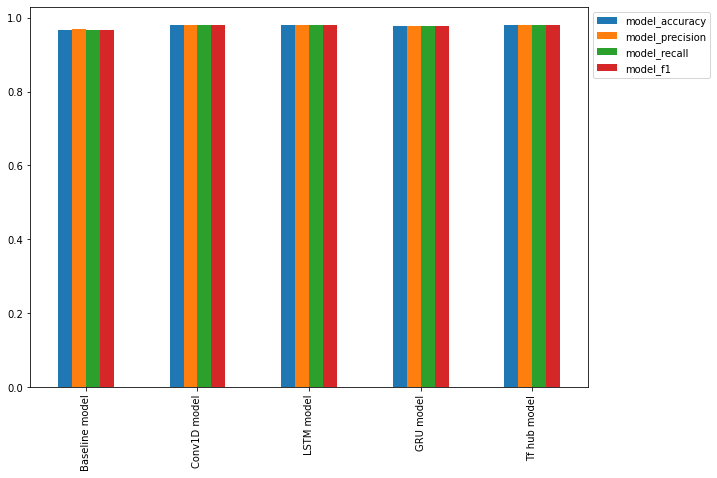

In [40]:
# Plot and compare all of the model results
all_model_result.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

Looking at the Dataframe above, the LSTM model is the best performing model

### Getting the most wrong prediction from the best performing model

In [41]:
# Creating DataFrame with validation sentences, validation labels and best performing model predictions labels(LSTM model)
val_df=pd.DataFrame({"text":val_sentences,
                     "target":val_labels_encoded,
                     "preds": model_2_preds})
val_df.head()

,text,target,preds
0,Great comedy..cant stop laughing da:),0,0.0
1,Its sarcasm.. .nt scarcasim,0,0.0
2,We tried to contact you re your reply to our o...,1,1.0
3,FreeMsg: Claim ur 250 SMS messages-Text OK to ...,1,1.0
4,Ya that one is slow as poo,0,0.0


In [42]:
# Getting the most wrong predictions of the model
most_wrong_prediction=val_df[val_df["target"]!=val_df["preds"]]
most_wrong_prediction.head()

,text,target,preds
15,"Fuuuuck I need to stop sleepin, sup",0,1.0
19,\Hi missed your Call and my mumHas beendroppin...,0,1.0
115,Total video converter free download type this ...,0,1.0
129,Cashbin.co.uk (Get lots of cash this weekend!)...,1,0.0
248,This message is from a great Doctor in India:-...,0,1.0


In [43]:
# Getting target labels
label_encoder.classes_

array(['ham', 'spam'], dtype=object)

### Making predictions with the best performing model on custom data

In [44]:
# Getting custom data 
custom_data_1="I'll be at the bus station at 10am"
custom_data_2="This text is free. Welcome to the club house &/, ! Visit our page for more info, To unsubscribe from text, reply STOP. msgs@150p 18+only"
custom_data_3="Hi Dan, would you love to come with us to the club tonight"

In [45]:
# Creating a function to make predictions on custom data
def predict_text(text,model):
  pred_probs=model.predict([text])
  pred=tf.squeeze(tf.round(pred_probs).numpy())
  return print(f"Pred: {pred}, Pred_probs: {pred_probs[0][0]:.3f}","(Spam)" if pred>0  else "(Not spam)")

In [46]:
# Making predictions with model_2 on the custom_data_1
predict_text(text=custom_data_1,model=model_4)

Pred: 0.0, Pred_probs: 0.000 (Not spam)


In [47]:
# Making predictions with model_2 on the custom_data_2
predict_text(text=custom_data_2,model=model_4)

Pred: 1.0, Pred_probs: 1.000 (Spam)


In [48]:
# Making predictions with model_2 on the custom_data_3
predict_text(text=custom_data_3,model=model_4)

Pred: 0.0, Pred_probs: 0.000 (Not spam)
